In [1]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split



from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = 1
DATA_DIR = "/kaggle/input/raindrop-dataset-parking-night-scenario/RaindropsOnWindshield_NewDataset2"
input_dir = '../input/raindrop-dataset-parking-night-scenario/RaindropsOnWindshield_NewDataset2/images'
mask_dir = '../input/raindrop-dataset-parking-night-scenario/RaindropsOnWindshield_NewDataset2/masks'
NUM_TRAIN_IMAGES = 1000
NUM_VAL_IMAGES = 50
split = 0.1
images = [os.path.join(pth, f) for pth, dirs, files in os.walk(input_dir) for f in files]
masks = [os.path.join(pth, f) for pth, dirs, files in os.walk(mask_dir) for f in files]
total_size = len(images)
valid_size = int(split * total_size)
test_size = int(split * total_size)

print(total_size)
print(valid_size)
print(test_size)

train_images, val_images = train_test_split(images, test_size=valid_size, random_state=42)
train_masks, val_masks = train_test_split(masks, test_size=valid_size, random_state=42)

train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
train_masks, test_masks = train_test_split(masks, test_size=test_size, random_state=42)
   

    


16697
1669
1669


In [3]:
'''def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x



def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

train_dataset = tf_dataset(train_images, train_masks, batch=BATCH_SIZE)
val_dataset = tf_dataset(val_images, val_masks, batch=BATCH_SIZE)'''

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image/255.0
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
        image = image/255.0
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)


print(len(train_images))
print(len(train_masks))
print(len(val_images))
print(len(val_masks))
print(train_dataset)
print(val_dataset)

x = read_image(train_images[1], mask=False)
y = read_image(train_masks[1], mask=True)
print(x.shape)
print(y.shape)




15028
15028
1669
1669
<_BatchDataset element_spec=(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(32, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32, 256, 256, 1), dtype=tf.float32, name=None))>
(256, 256, 3)
(256, 256, 1)


**Model**

In [4]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

**Print images**

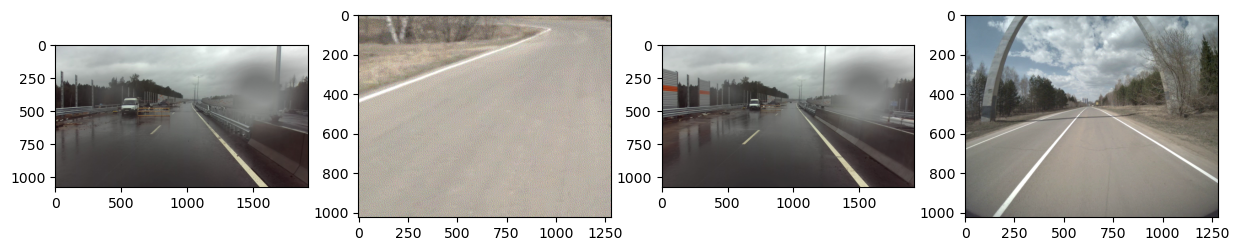

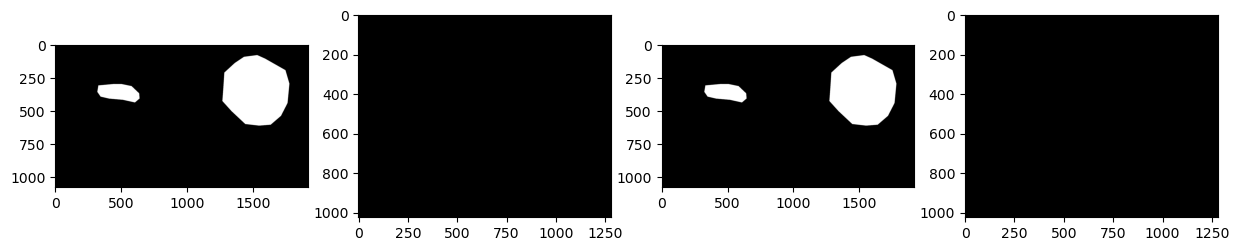

In [5]:
import matplotlib.pyplot as plt
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_images[100]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_images[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_images[2050]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_images[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_masks[100]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_masks[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_masks[2050]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_masks[3]))
imgplot.set_clim(0.0, 1.4)


**Training**

In [6]:
#loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
"""smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

metrics = [dice_coef, Recall(), Precision()]"""

model.compile(
    optimizer=tf.keras.optimizers.Nadam(1e-4),
    loss=loss,
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=False),
    ModelCheckpoint("./raindrops_segmentation_unet_mobilenetv2.h5", monitor='val_loss', verbose=0, 
                            save_best_only=True, mode='min')
]


history = model.fit(train_dataset, validation_data=val_dataset, epochs=50, callbacks=callbacks)

Epoch 1/50
469/469 [==============================] - 462s 829ms/step - loss: 0.1777 - accuracy: 0.9503 - val_loss: 0.7879 - val_accuracy: 0.2668 - lr: 1.0000e-04
Epoch 2/50
469/469 [==============================] - 360s 767ms/step - loss: 0.0984 - accuracy: 0.9627 - val_loss: 0.2624 - val_accuracy: 0.9193 - lr: 1.0000e-04
Epoch 3/50
469/469 [==============================] - 317s 675ms/step - loss: 0.0669 - accuracy: 0.9740 - val_loss: 0.0543 - val_accuracy: 0.9795 - lr: 1.0000e-04
Epoch 4/50
469/469 [==============================] - 312s 664ms/step - loss: 0.0609 - accuracy: 0.9757 - val_loss: 0.0707 - val_accuracy: 0.9741 - lr: 1.0000e-04
Epoch 5/50
469/469 [==============================] - 319s 679ms/step - loss: 0.0746 - accuracy: 0.9706 - val_loss: 0.0618 - val_accuracy: 0.9775 - lr: 1.0000e-04
Epoch 6/50
469/469 [==============================] - 322s 686ms/step - loss: 0.0512 - accuracy: 0.9795 - val_loss: 0.0471 - val_accuracy: 0.9824 - lr: 1.0000e-04
Epoch 7/50
469/469 [==

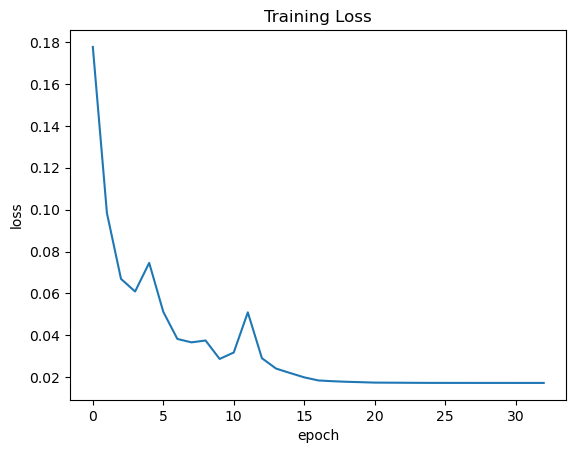

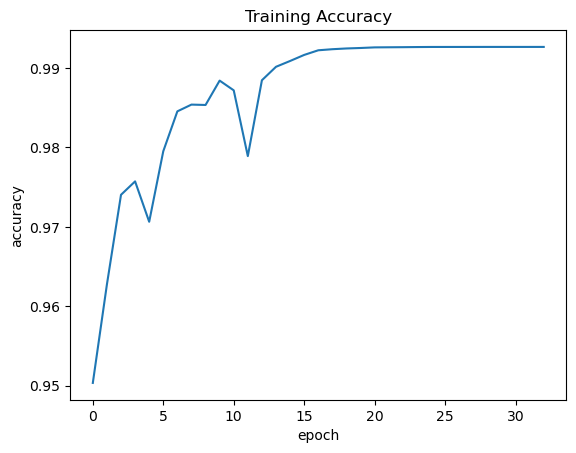

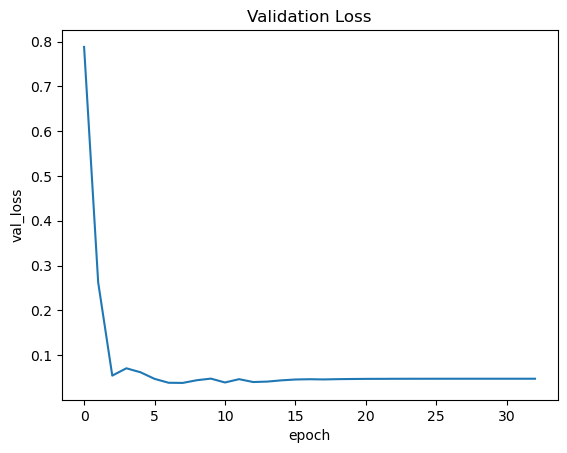

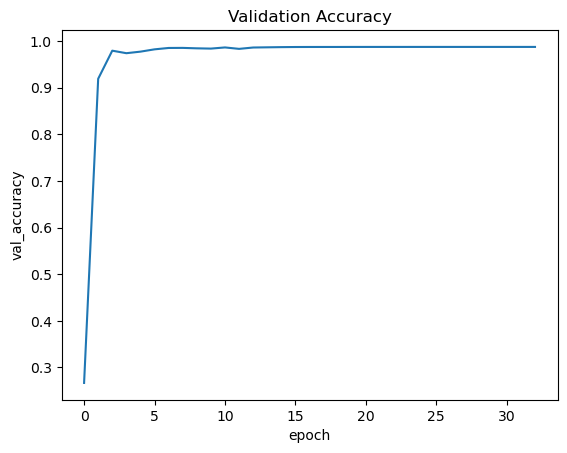

In [7]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [8]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x


def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 2s 2s/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 24ms/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 24ms/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 27ms/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 27ms/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 31ms/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 57ms/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 24ms/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 23ms/step
(256, 256, 1)
(256, 256, 3)
(256, 256, 1)
1/1 [==============================] - 0s 23ms/step
(256, 256, 1)


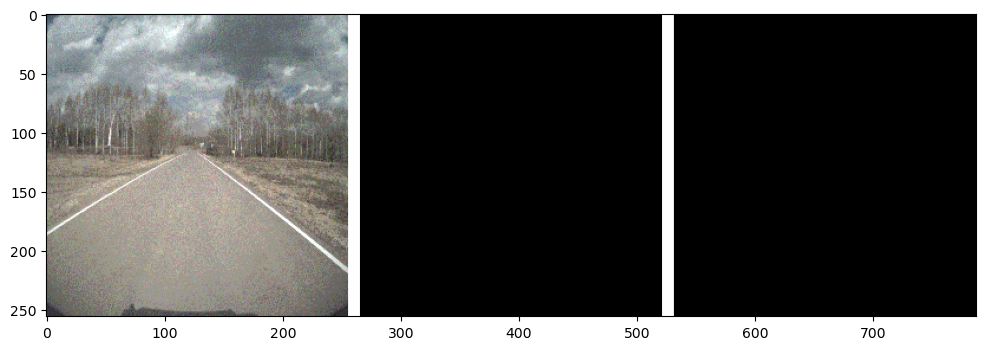

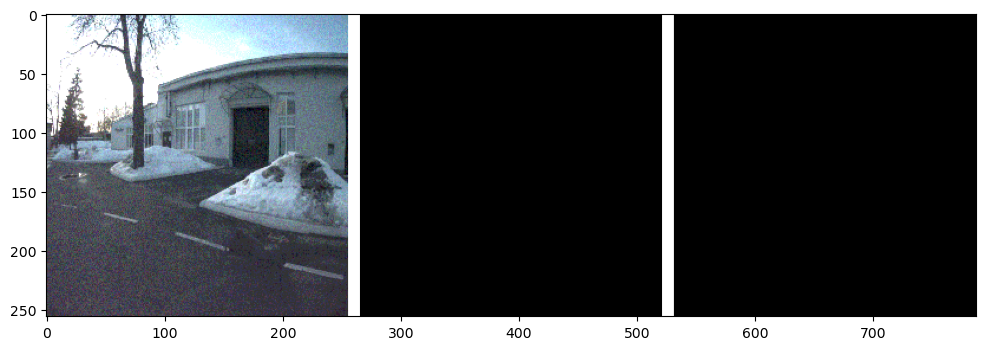

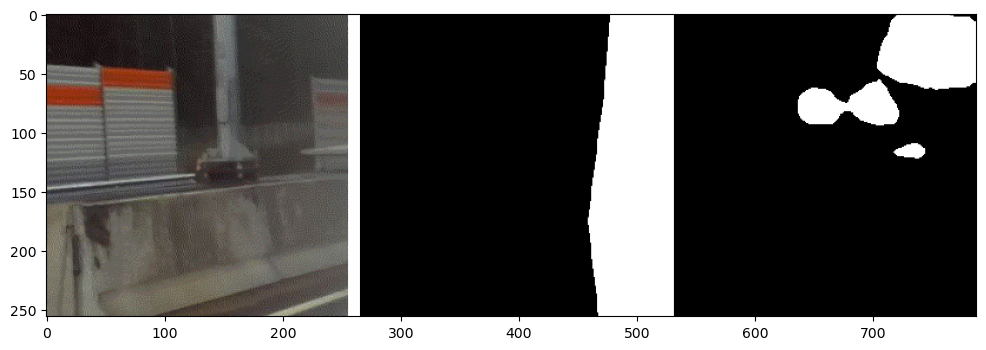

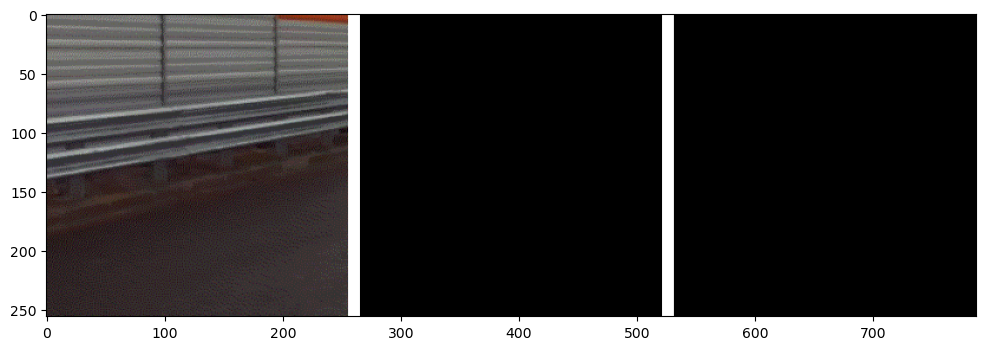

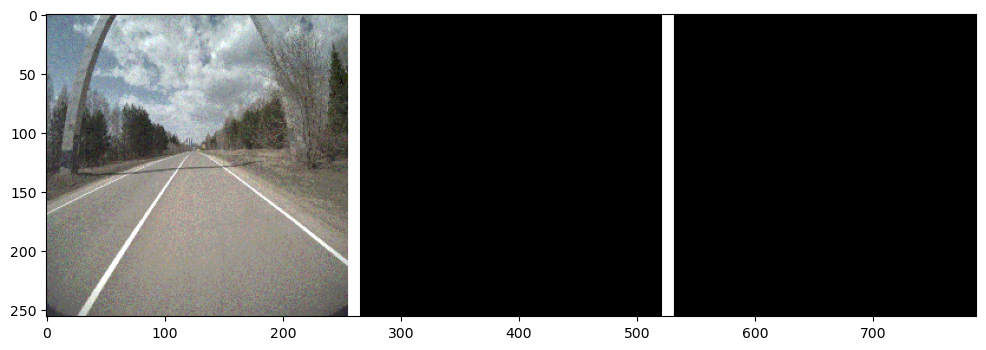

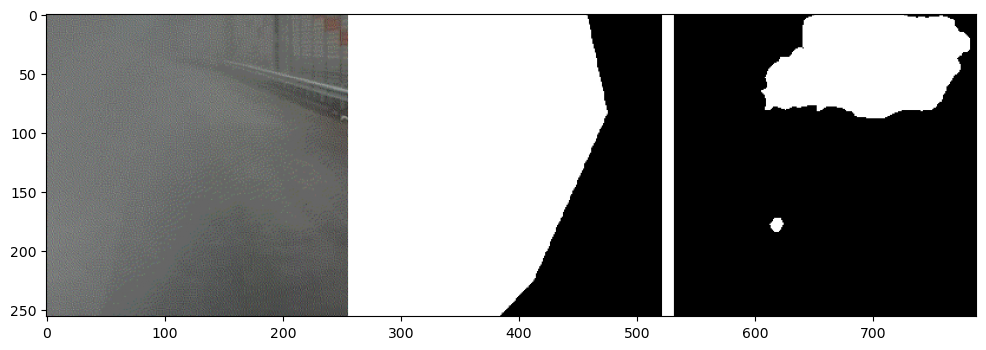

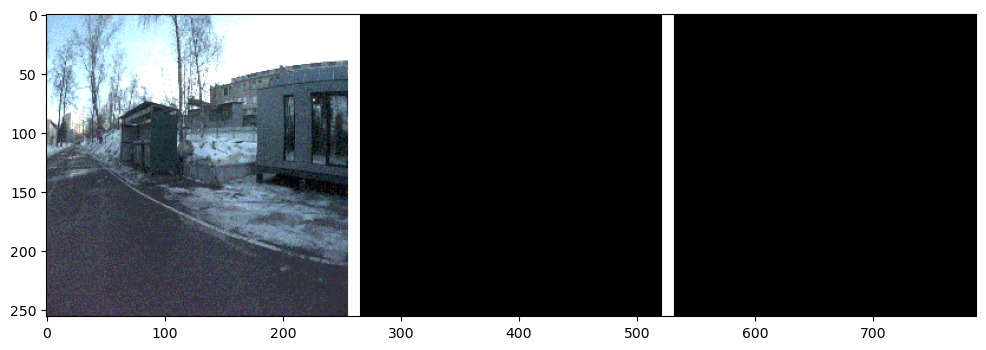

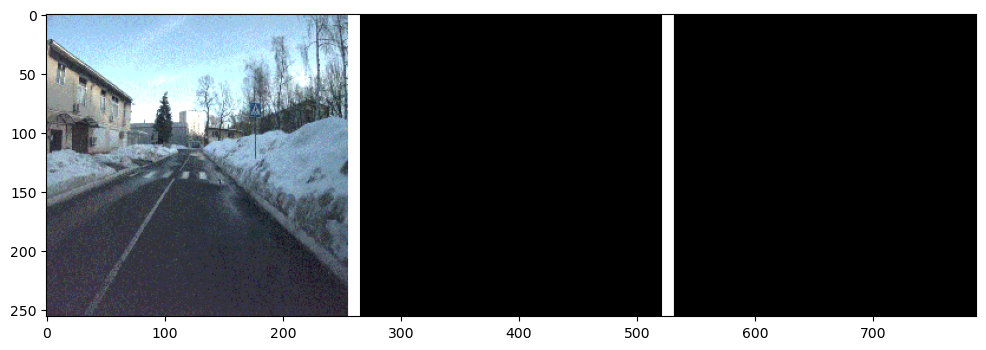

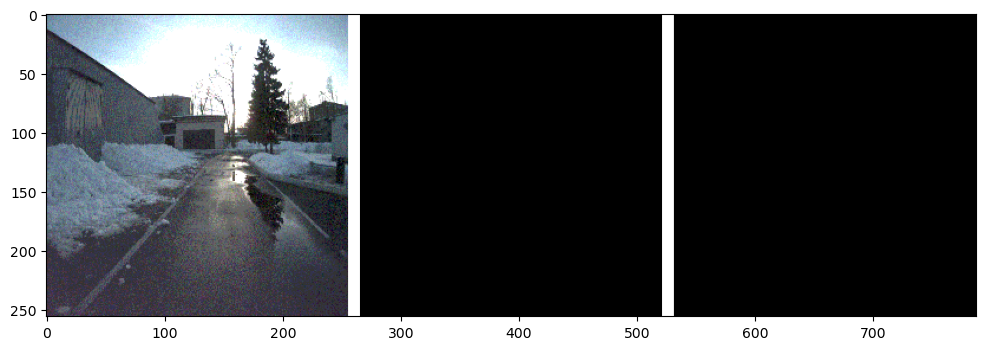

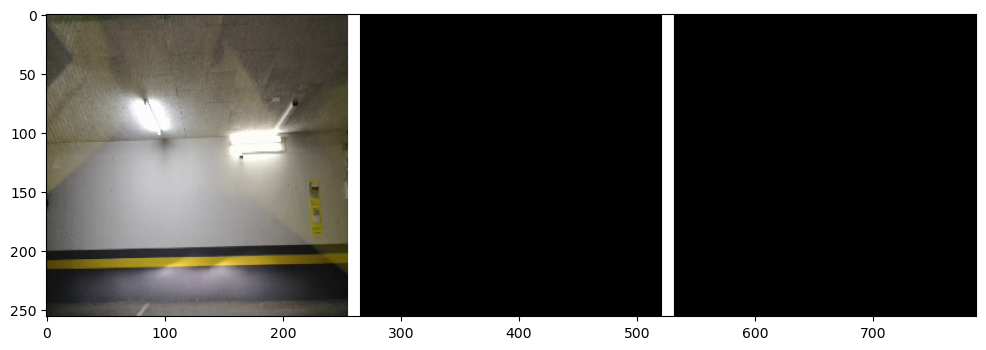

In [9]:
for i, (x, y) in enumerate(zip(test_images[:10], test_masks[:10])):
    x = read_image(x)
    y = read_mask(y)
    print(x.shape)
    print(y.shape)
    
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    print(y_pred.shape)
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)